# Зависимости



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Веселье с PyLDAVis

In [2]:
import random
import re
import string
import pandas as pd
import torch
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import gensim
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaMulticore
from torch import nn
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader
from torchvision.transforms import ToTensor
import warnings 
from sklearn.linear_model import LogisticRegression
from PIL import Image
from IPython.display import clear_output


In [3]:
warnings.filterwarnings(action='ignore',category=UserWarning, module='gensim')  
warnings.filterwarnings(action='ignore',category=FutureWarning, module='gensim')  
warnings.filterwarnings(action='ignore',category=DeprecationWarning, module='gensim')
warnings.filterwarnings(action='ignore',category=DeprecationWarning, module='smart_open') 
warnings.filterwarnings(action='ignore',category=DeprecationWarning, module='sklearn')
warnings.filterwarnings(action='ignore',category=DeprecationWarning, module='scipy')    

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
data = pd.read_csv('/content/drive/MyDrive/aiijc_sber/tokens_full_cleaned.csv')

In [6]:
data.head()

,Unnamed: 0,texts,y,tokens
0,0,Живо́тные (лат. Animalia) — традиционно (со вр...,0,живо тный лата аристотель выделять организм би...
1,1,Пти́цы (лат. Aves) — группа теплокровных яйцек...,0,пти цы лата группа теплокровный яйцекладущий п...
2,2,Союз охраны птиц России (СОПР) — общероссийска...,0,союз охрана птица россия сопра общероссийский ...
3,3,Крючковидные отростки рёбер — костяные выросты...,0,крючковидный отросток ребро костяной вырост ве...
4,4,Myxozoa (лат.) — класс или подтип паразитическ...,0,лата класс подтип паразитический беспозвоночны...


In [7]:
fixed_tokens = []
empty = 0
for  tok in data.tokens:
  aslist = tok.split()
  fixed_tokens.append(aslist)
  empty += aslist.count('')
data.tokens = fixed_tokens

In [8]:
data.head()

,Unnamed: 0,texts,y,tokens
0,0,Живо́тные (лат. Animalia) — традиционно (со вр...,0,"[живо, тный, лата, аристотель, выделять, орган..."
1,1,Пти́цы (лат. Aves) — группа теплокровных яйцек...,0,"[пти, цы, лата, группа, теплокровный, яйцеклад..."
2,2,Союз охраны птиц России (СОПР) — общероссийска...,0,"[союз, охрана, птица, россия, сопра, общеросси..."
3,3,Крючковидные отростки рёбер — костяные выросты...,0,"[крючковидный, отросток, ребро, костяной, выро..."
4,4,Myxozoa (лат.) — класс или подтип паразитическ...,0,"[лата, класс, подтип, паразитический, беспозво..."


In [9]:
data = data.drop(['Unnamed: 0'], axis=1)

In [10]:
data.head()

,texts,y,tokens
0,Живо́тные (лат. Animalia) — традиционно (со вр...,0,"[живо, тный, лата, аристотель, выделять, орган..."
1,Пти́цы (лат. Aves) — группа теплокровных яйцек...,0,"[пти, цы, лата, группа, теплокровный, яйцеклад..."
2,Союз охраны птиц России (СОПР) — общероссийска...,0,"[союз, охрана, птица, россия, сопра, общеросси..."
3,Крючковидные отростки рёбер — костяные выросты...,0,"[крючковидный, отросток, ребро, костяной, выро..."
4,Myxozoa (лат.) — класс или подтип паразитическ...,0,"[лата, класс, подтип, паразитический, беспозво..."


In [11]:
# bigram = gensim.models.Phrases(data.tokens, min_count=10, threshold=100) 
# bigram_mod = gensim.models.phrases.Phraser(bigram)
# bigram_mod.save("/content/drive/MyDrive/aiijc_sber/bigram_model.pkl")

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

bigram_mod = gensim.models.Phrases.load("/content/drive/MyDrive/aiijc_sber/bigram_model.pkl")
processed_docs = make_bigrams(data.tokens)

In [12]:
glued = []
for i in processed_docs:
  glued.append(' '.join(i))

In [13]:
glued[1]

'пти цы лата группа теплокровный яйцекладущий позвоночный животное ранг класс обособить группа животное характерный признак покров перо предохранять тело неблагоприятный температура полёт полёт птица вид вторичный передний_конечность форма крыло птица строение орган дыхание пищеварение летать признак птица наличие клюв вид птица регулярный миграция регион земля перемещаться расстояние ареал птица социальный животное общаться визуальный звуковой_сигнал общественный действие коммунальный гнездование охота хищник вид характерный моногамия правило яйцо откладываться гнездо насиживаться член пара птица ухаживать потомство птица населять регион земной_шар антарктида международный союз орнитолог май вид жить птица подвид вид вымереть птица разнообразный класс четвероногий россия вид гнездиться вид вид гнездование страна вид группа позвоночный биология птица природа вид экономический птицеводство отрасль мясо яйцо жир перо вид птица содержаться животное деятельность птица получить уточнить ста

In [14]:
X_train, X_test, Y_train, Y_test = train_test_split(glued, data.y, test_size=0.1, random_state = 42)

In [15]:
my_tags = ['животные', "спорт", "литература", "музыка"]

In [19]:
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
import gensim
from gensim.models.doc2vec import TaggedDocument
import re

def label_sentences(corpus, label_type):
    """
    Gensim's Doc2Vec implementation requires each document/paragraph to have a label associated with it.
    We do this by using the TaggedDocument method. The format will be "TRAIN_i" or "TEST_i" where "i" is
    a dummy index of the post.
    """
    labeled = []
    for i, v in enumerate(corpus):
        label = label_type + '_' + str(i)
        labeled.append(TaggedDocument(v.split(), [label]))
    return labeled
X_train, X_test, y_train, y_test = train_test_split(data.texts, data.y, random_state=0, test_size=0.3)
X_train = label_sentences(X_train, 'Train')
X_test = label_sentences(X_test, 'Test')
all_data = X_train + X_test

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [20]:
all_data[:2]


[TaggedDocument(words=['Квадри́виум,', 'или', 'квадри́вий', '(лат.', 'quadrivium', '—', '«четырёхпутье»)', '—', 'общее', 'название', 'системы', 'точных', 'наук', 'в', 'Средние', 'века.', 'Квадривиум', 'включал', '4', 'дисциплины,', 'математизированные', 'на', 'то', 'время:', 'арифметику', '(считалась', 'базовой', 'дисциплиной),', 'геометрию,', 'астрономию,', 'музыку', '(подразумевается', 'наука', 'гармоника,', 'а', 'не', '«искусство', 'звуков»', 'и', 'тому', 'подобное),по', 'числу', 'которых', 'и', 'получил', 'название.', 'Квадривиум', 'составлял', 'повышенный', 'курс', 'светского', 'образования', 'в', 'средневековых', 'школах', 'и', 'университетах', '(следующий', 'за', 'тривиумом', '—', 'курсом', 'гуманитарных', 'наук,', 'составлявшим', 'в', 'них', 'начальный', 'курс).', 'Доктрина', 'семи', 'свободных', 'искусств,', 'разделявшихся', 'на', 'тривиум', 'и', 'квадривиум,', 'была', 'систематизирована', 'Марцианом', 'Капеллой', 'в', 'его', 'энциклопедическом', 'труде', '«О', 'бракосочетании

In [21]:
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, min_count=1, alpha=0.065, min_alpha=0.065)
model_dbow.build_vocab([x for x in tqdm(all_data)])

for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(all_data)]), total_examples=len(all_data), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha


100%|██████████| 1750/1750 [00:00<00:00, 633416.64it/s]


In [22]:
def get_vectors(model, corpus_size, vectors_size, vectors_type):
    """
    Get vectors from trained doc2vec model
    :param doc2vec_model: Trained Doc2Vec model
    :param corpus_size: Size of the data
    :param vectors_size: Size of the embedding vectors
    :param vectors_type: Training or Testing vectors
    :return: list of vectors
    """
    vectors = np.zeros((corpus_size, vectors_size))
    for i in range(0, corpus_size):
        prefix = vectors_type + '_' + str(i)
        vectors[i] = model.docvecs[prefix]
    return vectors
    
train_vectors_dbow = get_vectors(model_dbow, len(X_train), 300, 'Train')
test_vectors_dbow = get_vectors(model_dbow, len(X_test), 300, 'Test')

In [27]:
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report
logreg = LogisticRegression(n_jobs=1, C=1e5, max_iter=10000)
logreg.fit(train_vectors_dbow, y_train)
logreg = logreg.fit(train_vectors_dbow, y_train)
y_pred = logreg.predict(test_vectors_dbow)
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))


accuracy 0.5619047619047619
              precision    recall  f1-score   support

    животные       0.68      0.66      0.67       131
       спорт       0.50      0.58      0.54       136
  литература       0.54      0.55      0.54       136
      музыка       0.54      0.44      0.49       122

    accuracy                           0.56       525
   macro avg       0.56      0.56      0.56       525
weighted avg       0.56      0.56      0.56       525



In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(n_jobs=1, C=1e5, max_iter=1000)
logreg = logreg.fit(X_train_word_average, train['y'])
y_pred = logreg.predict(X_test_word_average)
print('accuracy %s' % accuracy_score(y_pred, test.y))
print(classification_report(test.y, y_pred,target_names=my_tags))

accuracy 0.7314285714285714
              precision    recall  f1-score   support

    животные       0.83      0.91      0.87        44
       спорт       0.77      0.75      0.76        36
  литература       0.66      0.74      0.70        42
      музыка       0.67      0.57      0.61        53

    accuracy                           0.73       175
   macro avg       0.73      0.74      0.73       175
weighted avg       0.73      0.73      0.73       175



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
# dictionary = Dictionary(processed_docs)
# dictionary.filter_extremes(no_below=1, no_above=0.1, keep_n= 100000)
# dictionary.save("/content/drive/MyDrive/aiijc_sber/bigram_dictionary")

dictionary = Dictionary.load("/content/drive/MyDrive/aiijc_sber/bigram_dictionary")

In [ ]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

In [ ]:
lda_model =  LdaMulticore(tqdm(bow_corpus), 
                          num_topics = 20, 
                          id2word = dictionary,                                    
                          passes = 20
                          )

lda_model.save("/content/drive/MyDrive/aiijc_sber/LDA_model_20_cleaned")
# lda_model = LdaMulticore.load("/content/drive/MyDrive/aiijc_sber/LDA_model_20")

100%|██████████| 4/4 [00:00<00:00, 10.86it/s]


In [ ]:
for idx, topic in lda_model.print_topics(-1):
    print("Topic: {} \nWords: {}".format(idx, topic ))
    print("\n")

Topic: 0 
Words: 0.000*"литература" + 0.000*"стать" + 0.000*"вид" + 0.000*"век" + 0.000*"история" + 0.000*"страна" + 0.000*"россия" + 0.000*"город" + 0.000*"мир" + 0.000*"война"


Topic: 1 
Words: 0.010*"музыка" + 0.006*"музыкальный" + 0.004*"стать" + 0.004*"форма" + 0.003*"ссср" + 0.003*"инструмент" + 0.003*"группа" + 0.003*"век" + 0.003*"россия" + 0.003*"слово"


Topic: 2 
Words: 0.000*"вид" + 0.000*"литература" + 0.000*"страна" + 0.000*"стать" + 0.000*"форма" + 0.000*"мир" + 0.000*"история" + 0.000*"россия" + 0.000*"группа" + 0.000*"клетка"


Topic: 3 
Words: 0.000*"стать" + 0.000*"вид" + 0.000*"страна" + 0.000*"век" + 0.000*"история" + 0.000*"клетка" + 0.000*"группа" + 0.000*"музыка" + 0.000*"россия" + 0.000*"форма"


Topic: 4 
Words: 0.000*"литература" + 0.000*"стать" + 0.000*"форма" + 0.000*"мир" + 0.000*"история" + 0.000*"музыка" + 0.000*"вид" + 0.000*"россия" + 0.000*"слово" + 0.000*"век"


Topic: 5 
Words: 0.000*"вид" + 0.000*"век" + 0.000*"история" + 0.000*"стать" + 0.000*"му

In [ ]:
visualization_data = gensimvis.prepare(lda_model, bow_corpus, dictionary, mds='mmds')
pyLDAvis.display(visualization_data)

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [ ]:
features = []
volume = len(data)
counter = 0
for item in data.tokens:
    counter+=1
    lda_scores = lda_model.get_document_topics(dictionary.doc2bow(item))
    asfeatures = [0. for i in range(20)]
    for theme, score in lda_scores:
          asfeatures[theme] = score
    features.append(asfeatures)
    if counter%10000 == 0:
      print("Done", counter, "from", volume)

Done 10000 from 119850
Done 20000 from 119850
Done 30000 from 119850
Done 40000 from 119850
Done 50000 from 119850
Done 60000 from 119850
Done 70000 from 119850
Done 80000 from 119850
Done 90000 from 119850
Done 100000 from 119850
Done 110000 from 119850


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(torch.Tensor(features), torch.Tensor(data.y), test_size = 0.1, shuffle=True)

In [ ]:
train_dataset = TensorDataset(X_train, Y_train)
test_dataset = TensorDataset(X_test, Y_test)

BATCH_SIZE = 64
train_dl = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dl = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
clf = LogisticRegression(random_state=0, max_iter=1000).fit(X_train, Y_train)

In [ ]:
clf.score(X_test, Y_test)

0.7205673758865249

In [ ]:
model = nn.Sequential(
    nn.Linear(20, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),

    nn.Linear(64, 4)
)

optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum = 0.9)
criterion = nn.CrossEntropyLoss()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)
print(device)

cpu


In [ ]:
def plot_history(train_history, val_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)
    
    points = np.array(val_history)
    steps = list(range(0, len(train_history) + 1, int(len(train_history) / len(val_history))))[1:]
    
    plt.scatter(steps, val_history, marker='+', s=180, c='orange', label='val', zorder=2)
    plt.xlabel('train steps')
    
    plt.legend(loc='best')
    plt.grid()

    plt.show()

def train(model, criterion, optimizer, train_dataloader, test_dataloader, NUM_EPOCH=15):
    train_loss_log = []
    val_loss_log = []
    
    train_acc_log = []
    val_acc_log = []
    
    for epoch in tqdm(range(NUM_EPOCH)):
        model.train()
        train_loss = 0.
        train_size = 0
        
        train_pred = 0.

        for imgs, labels in train_dataloader:
            optimizer.zero_grad()

            y_pred = model.forward(imgs)

            loss = criterion(y_pred, labels.long())
            loss.backward()
            
            train_loss += loss.item()
            train_size += y_pred.size(0)
            train_loss_log.append(loss.data / y_pred.size(0))
            
            train_pred += (y_pred.argmax(1) == labels).sum()

            optimizer.step()
        
        train_acc_log.append(train_pred / train_size)

        val_loss = 0.
        val_size = 0
        
        val_pred = 0.
        
        model.eval()
        
        with torch.no_grad():
            for imgs, labels in test_dataloader:
                
                
                pred = model.forward(imgs)
                loss = criterion(pred, labels.long())
                
                val_loss += loss.item()
                val_size += pred.size(0)
                
                val_pred += (pred.argmax(1) == labels).sum()

        val_loss_log.append(val_loss / val_size)
        val_acc_log.append(val_pred / val_size)

        clear_output()
        plot_history(train_loss_log, val_loss_log, 'loss')

        print('Train loss:', (train_loss / train_size)*100)
        print('Val loss:', (val_loss / val_size)*100)
        print('Train acc:', (train_pred / train_size)*100)
        print('Val acc:', (val_pred / val_size)*100)
        
    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

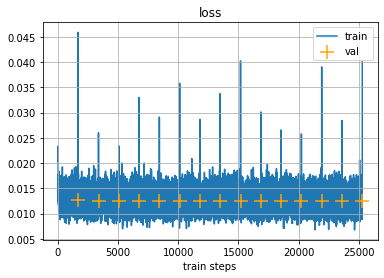

100%|██████████| 15/15 [00:39<00:00,  2.67s/it]

Train loss: 1.2537947795114017
Val loss: 1.2427058096075239
Train acc: tensor(72.0271)
Val acc: tensor(72.3154)


In [ ]:
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(model, 
                                                                 criterion, 
                                                                 optimizer, 
                                                                 train_dl, 
                                                                 test_dl)

Try 5 topics


In [ ]:
lda_model =  LdaMulticore(tqdm(bow_corpus), 
                          num_topics = 5, 
                          id2word = dictionary,                                    
                          passes = 20
                          )

lda_model.save("/content/drive/MyDrive/aiijc_sber/LDA_model_5_cleared")
# lda_model = LdaMulticore.load("/content/drive/MyDrive/aiijc_sber/LDA_model_5")

100%|██████████| 4/4 [00:00<00:00, 22.32it/s]


In [ ]:
visualization_data = gensimvis.prepare(lda_model, bow_corpus, dictionary, mds='mmds')
pyLDAvis.display(visualization_data)

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [ ]:
features = []
volume = len(data)
counter = 0
for item in data.tokens:
    counter+=1
    lda_scores = lda_model.get_document_topics(dictionary.doc2bow(item))
    asfeatures = [0. for i in range(5)]
    for theme, score in lda_scores:
          asfeatures[theme] = score
    features.append(asfeatures)
    if counter%10000 == 0:
      print("Done", counter, "from", volume)

Done 10000 from 119850
Done 20000 from 119850
Done 30000 from 119850
Done 40000 from 119850
Done 50000 from 119850
Done 60000 from 119850
Done 70000 from 119850
Done 80000 from 119850
Done 90000 from 119850
Done 100000 from 119850
Done 110000 from 119850


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(torch.Tensor(features), torch.Tensor(data.y), test_size = 0.1, shuffle=True)
train_dataset = TensorDataset(X_train, Y_train)
test_dataset = TensorDataset(X_test, Y_test)

BATCH_SIZE = 64
train_dl = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dl = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
clf = LogisticRegression(random_state=0, max_iter=1000).fit(X_train, Y_train)

In [ ]:
clf.score(X_test, Y_test)

0.592991239048811

Попробуем на 16. Почему 16? Да по приколу


In [ ]:
lda_model =  LdaMulticore(tqdm(bow_corpus), 
                          num_topics = 16, 
                          id2word = dictionary,                                    
                          passes = 20
                          )

lda_model.save("/content/drive/MyDrive/aiijc_sber/LDA_model_16_cleared")

100%|██████████| 4/4 [00:00<00:00, 12.81it/s]


In [ ]:
features = []
volume = len(data)
counter = 0
for item in data.tokens:
    counter+=1
    lda_scores = lda_model.get_document_topics(dictionary.doc2bow(item))
    asfeatures = [0. for i in range(16)]
    for theme, score in lda_scores:
          asfeatures[theme] = score
    features.append(asfeatures)
    if counter%10000 == 0:
      print("Done", counter, "from", volume)

Done 10000 from 119850
Done 20000 from 119850
Done 30000 from 119850
Done 40000 from 119850
Done 50000 from 119850
Done 60000 from 119850
Done 70000 from 119850
Done 80000 from 119850
Done 90000 from 119850
Done 100000 from 119850
Done 110000 from 119850


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(torch.Tensor(features), torch.Tensor(data.y), test_size = 0.1, shuffle=True)
train_dataset = TensorDataset(X_train, Y_train)
test_dataset = TensorDataset(X_test, Y_test)

BATCH_SIZE = 64
train_dl = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dl = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
clf = LogisticRegression(random_state=0, max_iter=1000).fit(X_train, Y_train)

In [ ]:
clf.score(X_test, Y_test)

0.7112223612849395